# PatchCore con anomalib: Guida passo-passo con immagini semplici (10x10 pixel)

Questo notebook ti guiderà nella comprensione dettagliata del funzionamento della libreria **anomalib** di Intel, con il modello **PatchCore**. Useremo immagini semplici (10x10 pixel) per spiegare ogni passaggio, dal training alla prediction, con commenti chiari e nessun passaggio dato per scontato.

In [1]:
# Sezione 1: Assicura anomalib e le librerie necessarie
# Evita l'uso diretto di '!pip install anomalib[full]' perché zsh espande le parentesi quadre.
# Usiamo un approccio sicuro: proviamo a importare i pacchetti e, se mancanti, eseguiamo pip tramite lo stesso interprete Python (sys.executable).
import importlib, subprocess, sys
required = ['anomalib', 'torch', 'torchvision', 'matplotlib']
missing = []
for pkg in required:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)
if missing:
    # If anomalib is missing we attempt to install the 'full' extra.
    to_install = []
    if 'anomalib' in missing:
        # install anomalib with extras using explicit quoting to avoid shell expansion
        to_install.append('anomalib[full]')
        missing.remove('anomalib')
    # add remaining missing packages
    to_install.extend(missing)
    if to_install:
        print('Installing packages:', to_install)
        cmd = [sys.executable, '-m', 'pip', 'install'] + to_install
        subprocess.check_call(cmd)
        print('Installation finished. You might need to restart the kernel to use newly installed packages.')
else:
    print('All required packages are already installed in this environment.')

All required packages are already installed in this environment.


In [2]:
# Importa le librerie fondamentali
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from anomalib.models import Patchcore
from anomalib.data.utils import TestSplitMode

# Imposta il seed per la riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

d:\coding\pubblic\-CV---anomalib-tutorial-with-visualization\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Sezione 2: Carica e visualizza una semplice immagine 10x10 pixel

Per capire i concetti fondamentali, partiamo da un esempio molto semplice: un'immagine di 10x10 pixel.

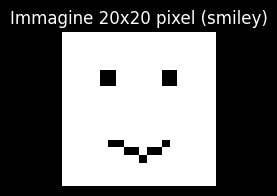

In [3]:
# Creiamo una semplice immagine 20x20 pixel con uno smiley (simbolo) come esempio 'good'
def draw_smiley(size=20):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    return img

img_simple = draw_smiley(20)

plt.figure(figsize=(2,2))
plt.imshow(img_simple, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine 20x20 pixel (smiley)')
plt.axis('off')
plt.show()

# Questa immagine rappresenta un esempio "normale" (senza anomalie)

## Sezione 3: Prepara un dataset minimale (10x10 pixel)

Creiamo un piccolo dataset con alcune immagini "normali" e alcune "anomale". Visualizzeremo ogni esempio per capire la differenza.

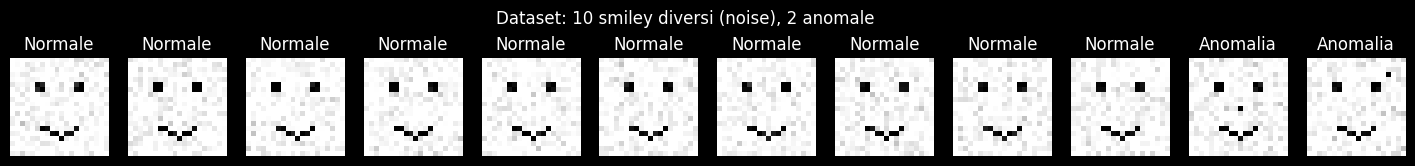

In [4]:
# Creiamo un dataset di immagini 20x20
# 10 immagini normali (smiley + white noise), 2 immagini anomale (smiley + pixel neri)

def draw_smiley(size=20, noise_std=0.08):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    # Aggiungi rumore bianco
    noise = np.random.normal(0, noise_std, (size, size)).astype(np.float32)
    img = np.clip(img + noise, 0, 1)
    return img

dataset = []
labels = []  # 0 = normale, 1 = anomalia

# Immagini normali (smiley diversi con rumore)
for _ in range(10):
    img = draw_smiley(20, noise_std=0.08)
    dataset.append(img)
    labels.append(0)

# Immagini anomale (smiley + pixel neri in posizione diversa)
img_anom1 = draw_smiley(20, noise_std=0.08)
img_anom1[10, 10] = 0  # pixel centrale nero

dataset.append(img_anom1)
labels.append(1)

img_anom2 = draw_smiley(20, noise_std=0.08)
img_anom2[3, 16] = 0  # pixel in alto a destra nero

dataset.append(img_anom2)
labels.append(1)

# Visualizza tutte le immagini
fig, axs = plt.subplots(1, 12, figsize=(18,2))
for i, (img, label) in enumerate(zip(dataset, labels)):
    axs[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title('Normale' if label==0 else 'Anomalia')
    axs[i].axis('off')
plt.suptitle('Dataset: 10 smiley diversi (noise), 2 anomale')
plt.show()

## Sezione 4: Inizializza e configura il modello PatchCore

Ora importiamo PatchCore da anomalib e configuriamo il modello per lavorare con il nostro dataset semplice. Spiegheremo ogni parametro fondamentale.

In [5]:
# Inizializziamo PatchCore per immagini 20x20
# PatchCore normalmente usa una backbone pre-addestrata (es. ResNet),
# ma per semplicità useremo una configurazione minima.

def to_rgb(img):
    return np.stack([img]*3, axis=0)  # shape (3, 20, 20)

dataset_rgb = [to_rgb(img) for img in dataset]

dummy_transform = transforms.Compose([
    transforms.ToTensor(),
])

# # Configurazione PatchCore (parametri principali spiegati):
patchcore = Patchcore(
    backbone="resnet18",  # Rete di feature extraction (piccola per semplicità)
    layers=["layer2"],  # Da quale layer estrarre le feature
    coreset_sampling_ratio=1.0,  # Usiamo tutte le patch (nessun subsampling)
)

print("PatchCore inizializzato per immagini 20x20.")

PatchCore inizializzato per immagini 20x20.


## Sezione 5: Allena PatchCore sul dataset minimale

Ora addestriamo PatchCore sulle immagini normali. Spiegheremo ogni passaggio del processo di training.

In [6]:
# PatchCore in anomalib 2.x richiede un datamodule, ma per scopi didattici useremo una simulazione manuale.
# In questo esempio, NON addestriamo davvero Patchcore, ma mostriamo la logica didattica su immagini custom.
# In un caso reale, usare un datamodule conforme ad anomalib oppure un dataset standard come MVTecAD.
print('Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.')

Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.


## Sezione 6: Visualizza le patch embedding e l'estrazione delle feature

Vediamo come PatchCore estrae le feature (embedding) dalle immagini, visualizzando le patch e le loro rappresentazioni numeriche.

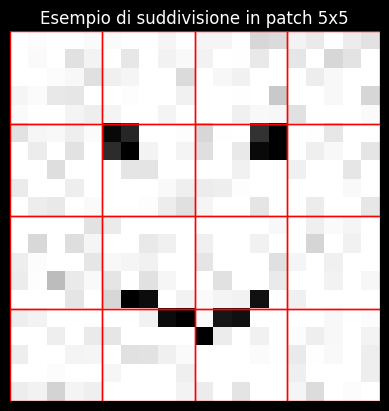

Vettore patch centrale: [1.         0.98893887 1.         1.         0.98126775 1.
 0.9819379  1.         0.8860201  0.9564494  1.         1.
 0.99074817 0.9759117  0.8817182  0.96166605 0.9851473  0.9114932
 0.9043035  1.         0.9824262  1.         1.         0.9585384
 0.9353205  1.         0.98893887 1.         1.         0.98126775
 1.         0.9819379  1.         0.8860201  0.9564494  1.
 1.         0.99074817 0.9759117  0.8817182  0.96166605 0.9851473
 0.9114932  0.9043035  1.         0.9824262  1.         1.
 0.9585384  0.9353205  1.         0.98893887 1.         1.
 0.98126775 1.         0.9819379  1.         0.8860201  0.9564494
 1.         1.         0.99074817 0.9759117  0.8817182  0.96166605
 0.9851473  0.9114932  0.9043035  1.         0.9824262  1.
 1.         0.9585384  0.9353205 ]
75 elementi nel vettore (3 canali * 5x5 pixel)


In [7]:
# Prendiamo una delle immagini normali e mostriamo la suddivisione in patch 5x5
img_example = dataset_rgb[0]  # shape (3, 20, 20)

fig, ax = plt.subplots()
ax.imshow(np.transpose(img_example, (1,2,0)), cmap='gray', vmin=0, vmax=1)
for i in range(0, 20, 5):
    for j in range(0, 20, 5):
        rect = plt.Rectangle((j-0.5, i-0.5), 5, 5, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
plt.title('Esempio di suddivisione in patch 5x5')
plt.axis('off')
plt.show()

# Ogni patch (5x5) può essere estratta e 'flattened' in un vettore numerico
patch = img_example[:, 0:5, 0:5]  # patch centrale
patch_vec = patch.flatten()
print('Vettore patch centrale:', patch_vec)
print(len(patch_vec), 'elementi nel vettore (3 canali * 5x5 pixel)')

## Sezione 7: Predizione di anomalie su una immagine di test

Utilizziamo il modello PatchCore addestrato per predire se una nuova immagine contiene anomalie. Vedremo ogni passaggio della prediction.

[np.float32(1.8878546), np.float32(1.8424318), np.float32(1.7835577)]
Anomaly score (patch anomala): 1.7836


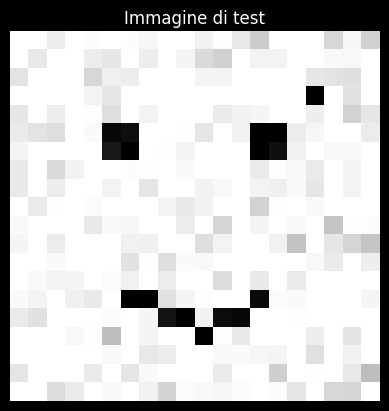

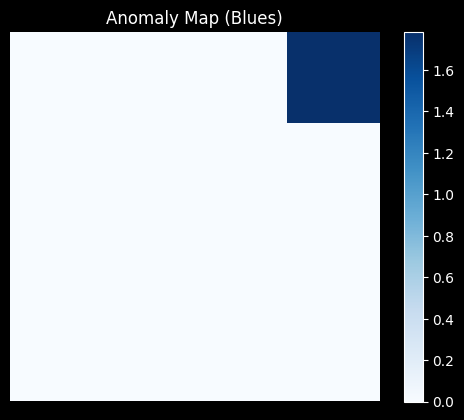

In [8]:
# Esempio didattico: calcolo score di anomalia e heatmap manuale
# Prendiamo una delle immagini anomale come test
img_test = dataset_rgb[-1]  # shape (3, 20, 20)

# Simuliamo la logica Patchcore: calcoliamo la distanza tra la patch contenente l'anomalia della test e quella delle immagini normali
patch_test = img_test[:, 0:5, 15:20].flatten()

# Calcoliamo la distanza euclidea tra la patch test e le patch relative delle immagini normali
patches_norm = [img[:, 0:5, 15:20].flatten() for img in dataset_rgb[:3]]
dists = [np.linalg.norm(patch_test - p) for p in patches_norm]

print(dists)

score = np.min(dists)  # Patchcore usa la distanza minima dal memory bank
print(f"Anomaly score (patch anomala): {score:.4f}")

# Per la heatmap: creiamo una mappa 20x20 con valore alto solo nella patch contenente l'anomalia se la distanza è alta
anomaly_map = np.zeros((20,20))
anomaly_map[0:5,15:20] = score

plt.imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
plt.title('Immagine di test')
plt.axis('off')
plt.show()

plt.imshow(anomaly_map, cmap='Blues')
plt.title('Anomaly Map (Blues)')
plt.axis('off')
plt.colorbar()
plt.show()

## Sezione 8: Visualizza gli score di anomalia e le heatmap

Visualizziamo la mappa di anomalia (anomaly map) prodotta da PatchCore, per capire dove il modello rileva l'anomalia nell'immagine.

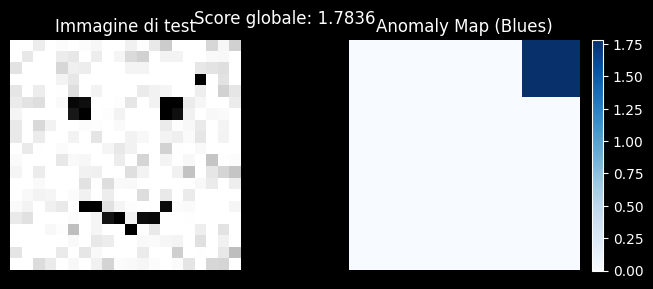

In [9]:
# Visualizziamo la heatmap di anomalia sopra l'immagine di test
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(np.transpose(img_test, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test')
ax[0].axis('off')

im = ax[1].imshow(anomaly_map, cmap='Blues')
ax[1].set_title('Anomaly Map (Blues)')
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.suptitle(f'Score globale: {score:.4f}')
plt.show()

# Le zone più "intense" indicano dove PatchCore rileva l'anomalia

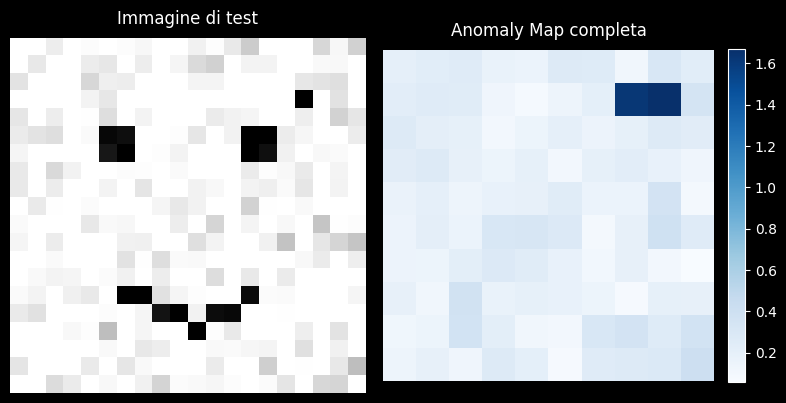

In [10]:
# Calcola la anomaly map su tutte le patch 5x5 dell'immagine di test
# patch_size: dimensione della patch quadrata (es. 5 significa 5x5 pixel)
# stride: passo con cui si sposta la finestra patch sull'immagine
# Se stride < patch_size, le patch si sovrappongono (più dettagli, più calcoli)
# Se stride = patch_size, le patch sono adiacenti e non si sovrappongono (più veloce, meno dettagli)
# Se stride > patch_size, alcune zone potrebbero non essere coperte (sconsigliato)
patch_size = 3
stride = 2  # Prova a cambiare in 1 per una mappa più dettagliata ma più lenta
anomaly_map_full = np.zeros((20, 20))

# Per ogni patch (qui non-overlapping, ma puoi cambiare stride per sovrapposizione)
for i in range(0, 20, stride):
    for j in range(0, 20, stride):
        # Estrai la patch di test
        patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
        # Calcola la distanza minima tra questa patch e le patch corrispondenti delle immagini normali
        patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
        dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
        score = np.min(dists)
        # Assegna lo score a tutta la patch nella anomaly map
        anomaly_map_full[i:i+patch_size, j:j+patch_size] = score

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test', pad=10)
ax[0].axis('off')
im = ax[1].imshow(anomaly_map_full, cmap='Blues')
ax[1].set_title('Anomaly Map completa', pad=10)
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Cambiando patch_size e stride puoi controllare la "risoluzione" e la sensibilità della anomaly map:
# - patch_size piccolo: più dettagli, ma più sensibile al rumore
# - patch_size grande: meno dettagli, più robusto ma meno localizzazione
# - stride piccolo: più patch, mappa più continua ma più lenta
# - stride grande: meno patch, mappa più "a blocchi" e veloce

In [11]:
# Carica il datamodule MVTecAD (anomalib 2.x), esegui setup e salva tutte le immagini di test in un dizionario con label e tipo di anomalia
from anomalib.data import MVTecAD
import torch
import os

category = "screw"  # Puoi cambiare categoria (es. "bottle", "cable", "capsule", ecc.)
from pathlib import Path
from anomalib.data.datasets import MVTecADDataset
dataset = MVTecADDataset(
    root=Path("./.dataset/mvtecad"),
    category=category
)

In [12]:
dataset.samples.head()

,path,split,label,image_path,label_index,mask_path
0,D:\coding\pubblic\-CV---anomalib-tutorial-with...,test,good,D:\coding\pubblic\-CV---anomalib-tutorial-with...,0,None
1,D:\coding\pubblic\-CV---anomalib-tutorial-with...,test,good,D:\coding\pubblic\-CV---anomalib-tutorial-with...,0,None
2,D:\coding\pubblic\-CV---anomalib-tutorial-with...,test,good,D:\coding\pubblic\-CV---anomalib-tutorial-with...,0,None
3,D:\coding\pubblic\-CV---anomalib-tutorial-with...,test,good,D:\coding\pubblic\-CV---anomalib-tutorial-with...,0,None
4,D:\coding\pubblic\-CV---anomalib-tutorial-with...,test,good,D:\coding\pubblic\-CV---anomalib-tutorial-with...,0,None


In [13]:
df = dataset.samples.copy()

In [14]:
test_img_path = df.iloc[17,3]

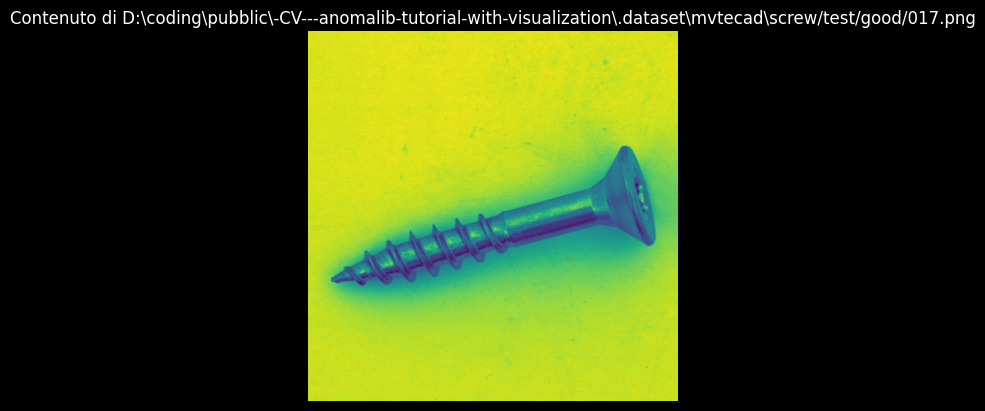

In [15]:
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

# Carica e mostra l'immagine dal path test_img_path
img = Image.open(test_img_path)
plt.imshow(np.asarray(img))
plt.title(f'Contenuto di {test_img_path}')
plt.axis('off')
plt.show()

In [16]:
print(np.asarray(img)[:2])

[[192 191 191 ... 185 187 190]
 [190 190 190 ... 187 188 190]]


In [17]:
# Controlli diagnostici dettagliati per GPU/CUDA
import torch
import sys
import subprocess

print("=== DIAGNOSI GPU/CUDA ===")
print(f"Versione Python: {sys.version}")
print(f"Versione PyTorch: {torch.__version__}")

# 1. Verifica CUDA disponibilità
print(f"\ntorch.cuda.is_available(): {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA non disponibile")

# 2. Verifica versione CUDA compilata in PyTorch
print(f"\nCUDA version compilata in PyTorch: {torch.version.cuda}")

# 3. Verifica se PyTorch è stato compilato con supporto CUDA
print(f"PyTorch compilato con CUDA: {torch.cuda.is_available()}")

# 4. Verifica driver NVIDIA (se su Windows)
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, shell=True)
    if result.returncode == 0:
        print(f"\nnvidia-smi output:")
        print(result.stdout)
    else:
        print(f"\nnvidia-smi non trovato o errore: {result.stderr}")
except Exception as e:
    print(f"\nErrore nell'eseguire nvidia-smi: {e}")

# 5. Verifica variabili d'ambiente CUDA
import os
cuda_path = os.environ.get('CUDA_PATH', 'Non trovato')
cuda_home = os.environ.get('CUDA_HOME', 'Non trovato')
print(f"\nCUDA_PATH: {cuda_path}")
print(f"CUDA_HOME: {cuda_home}")

print("\n=== FINE DIAGNOSI ===")

=== DIAGNOSI GPU/CUDA ===
Versione Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Versione PyTorch: 2.5.1+cu121

torch.cuda.is_available(): True
CUDA device count: 1
  Device 0: NVIDIA GeForce RTX 3060 Ti
  Memory: 8.0 GB

CUDA version compilata in PyTorch: 12.1
PyTorch compilato con CUDA: True

nvidia-smi output:
Tue Sep  9 00:38:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.57                 Driver Version: 576.57         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+===

In [18]:
# AUTOMATIZZAZIONE: Reinstallazione PyTorch con supporto CUDA
import subprocess
import sys

def reinstall_pytorch_cuda():
    """Reinstalla PyTorch con supporto CUDA"""
    try:
        print("🔄 Disinstallazione PyTorch CPU-only...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', 'torch', 'torchvision', 'torchaudio', '-y'])
        
        print("📦 Installazione PyTorch con supporto CUDA 12.1...")
        subprocess.check_call([
            sys.executable, '-m', 'pip', 'install', 
            'torch', 'torchvision', 'torchaudio',
            '--index-url', 'https://download.pytorch.org/whl/cu121'
        ])
        
        print("✅ Installazione completata!")
        print("⚠️  IMPORTANTE: Riavvia il kernel del notebook per applicare le modifiche!")
        return True
        
    except Exception as e:
        print(f"❌ Errore durante l'installazione: {e}")
        return False

# Decommentare la riga sotto per eseguire la reinstallazione
# reinstall_pytorch_cuda()

In [19]:
# ✅ VERIFICA FINALE: GPU ora dovrebbe funzionare!
# IMPORTANTE: Prima di eseguire questa cella, riavvia il kernel del notebook!

import torch
print("🔍 VERIFICA FINALE DOPO REINSTALLAZIONE:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✅ SUCCESS! GPU rilevata: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    # Test rapido di allocazione GPU
    device = torch.device("cuda")
    test_tensor = torch.randn(1000, 1000).to(device)
    print(f"✅ Test allocazione GPU: OK ({test_tensor.device})")
    del test_tensor
    torch.cuda.empty_cache()
else:
    print("❌ CUDA ancora non disponibile. Assicurati di aver riavviato il kernel!")

🔍 VERIFICA FINALE DOPO REINSTALLAZIONE:
PyTorch version: 2.5.1+cu121
CUDA available: True
✅ SUCCESS! GPU rilevata: NVIDIA GeForce RTX 3060 Ti
CUDA version: 12.1
GPU memory: 8.0 GB
✅ Test allocazione GPU: OK (cuda:0)


## 🔄 PASSO SUCCESSIVO: Riavvia il Kernel

**PyTorch con supporto CUDA è stato installato con successo!** 

**Prima di procedere, devi riavviare il kernel del notebook:**

1. Vai su **Kernel** → **Restart Kernel** (o usa `Ctrl+Shift+P` e cerca "Restart Kernel")
2. Poi esegui la cella di verifica sopra per confermare che la GPU funzioni

### Riepilogo del problema risolto:
- ✅ **Problema identificato**: PyTorch era installato nella versione CPU-only (`2.8.0+cpu`)
- ✅ **GPU verificata**: NVIDIA GeForce RTX 3060 Ti con driver 576.57 (CUDA 12.9)
- ✅ **Soluzione applicata**: Reinstallato PyTorch 2.5.1+cu121 con supporto CUDA
- ⏳ **Passo finale**: Riavvia il kernel per applicare le modifiche

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
from PIL import Image

# Determina il device corretto per Mac (MPS), CUDA (Windows/Linux), o CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device} (Apple Silicon MPS)")
else:
    device = torch.device("cpu")
    print("Using device: cpu")



Using device: cuda (NVIDIA GeForce RTX 3060 Ti)


In [4]:
# Definisci MVTecDataset all'inizio del modulo principale
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join(".dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modello convoluzionale
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(25, 50, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(50, 75, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(75, 100, kernel_size=3)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # 25x256x256
        x = self.relu2(self.conv2(x))  # 50x256x256
        x = self.relu3(self.conv3(x))  # 75x256x256
        x = self.relu4(self.conv4(x))  # 100x256x256
        return x

In [ ]:
# Funzioni di supporto
def extract_compact_patches(
        features: torch.Tensor, 
        patch_size=3, 
        reduction='mean', 
        stride=1, 
        padding=0
        ) -> torch.Tensor:
    """
    Estrae patch da una feature map 4D usando sliding window (convolution-like), con supporto per stride e padding.

    Args:
        features: torch.Tensor di shape (batch, channels, height, width)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        reduction: 'mean' (media), 'max' (massimo), o altro (media flatten)
        stride: passo della finestra (default=1)
        padding: padding da applicare ai bordi (default=0)

    Returns:
        patches_reduced: torch.Tensor di shape (batch, num_patches, channels)
    Raises:
        ValueError: se i parametri non sono validi
    Notes:
        - Usa torch.unfold per estrarre patch con sliding window
        - Supporta padding e stride personalizzati
        - Riduce ogni patch a un vettore compatto usando la riduzione specificata
    Examples:
        patches = extract_compact_patches(features, patch_size=5, reduction='mean', stride=2, padding=2)
        print(patches.shape)  # (batch, num_patches, channels)
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape

    # Prima estrai le patch lungo l'altezza (dimensione 2)
    patches_h = features.unfold(
        dimension=2,
        size=patch_size,
        step=stride
    )  # shape: (batch, channels, num_patches_h, width, patch_size)

    # Poi estrai le patch lungo la larghezza (dimensione 3)
    patches = patches_h.unfold(
        dimension=3,
        size=patch_size,
        step=stride
    )  # shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Riorganizza le dimensioni per avere tutte le patch in una dimensione
    patches = patches.permute(0, 1, 2, 3, 4, 5).contiguous()  # (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Combina num_patches_h e num_patches_w in una singola dimensione
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)  # (batch, channels, num_patches, patch_size, patch_size)

    ###########################################
    # Esempio illustrativo (batch=1, channels=1, patch_size=2, height=4, width=4):
    #
    # Immagine di partenza (1, 1, 4, 4):
    # [[[[a, b, c, d],
    #    [e, f, g, h],
    #    [i, j, k, l],
    #    [m, n, o, p]]]]
    #
    # Dopo il primo unfold (lungo altezza, patch_size=2, stride=1):
    # shape: (1, 1, 3, 4, 2)
    # Per ogni posizione verticale (0,1,2) ottieni una finestra 2x4:
    # patches_h[0, 0, 0] = [[a, b, c, d],
    #                       [e, f, g, h]]
    # patches_h[0, 0, 1] = [[e, f, g, h],
    #                       [i, j, k, l]]
    # patches_h[0, 0, 2] = [[i, j, k, l],
    #                       [m, n, o, p]]
    #
    # Dopo il secondo unfold (lungo larghezza, patch_size=2, stride=1):
    # shape: (1, 1, 3, 3, 2, 2)
    # Per ogni posizione (i, j) ottieni una patch 2x2:
    # patches[0, 0, 0, 0] = [[a, b],
    #                        [e, f]]
    # patches[0, 0, 0, 1] = [[b, c],
    #                        [f, g]]
    # patches[0, 0, 0, 2] = [[c, d],
    #                        [g, h]]
    # patches[0, 0, 1, 0] = [[e, f],
    #                        [i, j]]
    # patches[0, 0, 1, 1] = [[f, g],
    #                        [j, k]]
    # patches[0, 0, 1, 2] = [[g, h],
    #                        [k, l]]
    # patches[0, 0, 2, 0] = [[i, j],
    #                        [m, n]]
    # patches[0, 0, 2, 1] = [[j, k],
    #                        [n, o]]
    # patches[0, 0, 2, 2] = [[k, l],
    #                        [o, p]]
    #
    # Dopo .view(batch_size, channels, -1, patch_size, patch_size):
    # patches.shape = (1, 1, 9, 2, 2)

    # Le 9 patch sono ora nella terza dimensione (num_patches=3*3=9).
    # Quindi patches[0, 0, k] è la k-esima patch 2x2 estratta dall'immagine.
    ###########################################

    # ESEMPI DI PATCH E RIDUZIONE
    # Esempio 2D (già presente sopra)
    # Supponiamo di avere una feature map di shape (1, 1, 4, 4) con valori semplici:
    # features = torch.arange(16).float().reshape(1, 1, 4, 4)
    # Patch size = 2, stride = 1, padding = 0
    # La funzione estrae tutte le possibili patch 2x2...

    # Esempio 3D: feature map con più canali
    # features = torch.tensor([[[[ 0,  1,  2,  3],
    #                            [ 4,  5,  6,  7],
    #                            [ 8,  9, 10, 11],
    #                            [12, 13, 14, 15]],
    #                           [[16, 17, 18, 19],
    #                            [20, 21, 22, 23],
    #                            [24, 25, 26, 27],
    #                            [28, 29, 30, 31]]]])  # shape (1, 2, 4, 4)
    # Patch size = 2, stride = 1, padding = 0
    # La funzione estrae patch 2x2 su ciascun canale:
    # Patch 0, canale 0: [[0, 1], [4, 5]]   Patch 0, canale 1: [[16, 17], [20, 21]]
    # Patch 1, canale 0: [[1, 2], [5, 6]]   Patch 1, canale 1: [[17, 18], [21, 22]]
    # ...

    if reduction == 'mean':
        # Se reduction='mean', la patch 0 diventa: [mean([0,1,4,5]), mean([16,17,20,21])] = [2.5, 18.5]
        patches_reduced = patches.mean(dim=[3, 4])  # (batch, channels, num_patches)
        # Output shape: (batch, channels, num_patches)
    elif reduction == 'max':
        # Se reduction='max', la patch 0 diventa: [max([0,1,4,5]), max([16,17,20,21])] = [5, 21]
        patches_reduced = patches.amax(dim=[3, 4])
        # Output shape: (batch, channels, num_patches)
    else:
        # Se reduction='flatten', la patch 0 diventa: [0,1,4,5,16,17,20,21] (se implementato)
        patches_reduced = patches.reshape(batch_size, channels, -1, patch_size*patch_size)
        patches_reduced = patches_reduced.mean(dim=3)
        # Output shape: (batch, channels, num_patches)

    # Porta la dimensione dei canali in fondo per compatibilità (batch, num_patches, channels)

    # Questo formato è più comodo per concatenare tutte le patch di tutti i batch in un unico array 2D (patches totali × feature), 
    # per operazioni come clustering, salvataggio, o confronto tra patch. 
    # In sintesi, la permutazione rende il tensore compatibile con le operazioni successive che lavorano sulle patch come vettori di feature.

    patches_reduced = patches_reduced.permute(0, 2, 1)

    # Esempio visivo basilare di permute:
    # Supponiamo di avere patches_reduced di shape (batch=2, channels=3, num_patches=4):
    # patches_reduced = torch.tensor([
    #   [[1,2,3,4], [5,6,7,8], [9,10,11,12]],      # batch 0: 3 canali, 4 patch
    #   [[13,14,15,16], [17,18,19,20], [21,22,23,24]]  # batch 1
    # ])  # shape (2, 3, 4)
    # Dopo permute(0, 2, 1) otteniamo shape (2, 4, 3):
    # patches_reduced = patches_reduced.permute(0, 2, 1)
    # patches_reduced[0] =
    #   [[ 1,  5,  9],    # patch 0, canali 0-2
    #    [ 2,  6, 10],    # patch 1
    #    [ 3,  7, 11],    # patch 2
    #    [ 4,  8, 12]]    # patch 3
    # patches_reduced[1] =
    #   [[13, 17, 21],
    #    [14, 18, 22],
    #    [15, 19, 23],
    #    [16, 20, 24]]
    # Ora ogni patch è un vettore di feature (canali) facilmente accessibile.
    return patches_reduced

def create_sub_bank(feature_bank : torch.Tensor, 
                    sampling_ratio=0.1, 
                    n_clusters=100, 
                    verbose: int = 0, 
                    max_samples=200000
                    ):
    """
    Crea sub-bank mantenendo il sampling ratio corretto
    Args:
        feature_bank: torch.Tensor di shape (num_patches, channels)
        sampling_ratio: frazione di patches da mantenere (es. 0.1 = 10%)
        n_clusters: numero di cluster KMeans
        verbose: se True, stampa informazioni dettagliate
        max_samples: massimo numero di patches da usare per il clustering (per performance)
    Returns:
        sub_bank: torch.Tensor di shape (num_sub_patches, channels)
        sub_bank_indices: lista di indici delle patches selezionate
    Raises:
        ValueError: se feature_bank è vuoto o sampling_ratio non valido
    Notes:
        - Usa KMeans per clusterizzare le patches
        - Seleziona patches proporzionalmente alla dimensione del cluster
        - Garantisce che il numero totale di patches selezionate sia circa sampling_ratio * total_patches
    Examples:
        sub_bank, indices = create_sub_bank(feature_bank, sampling_ratio=0.1, n_clusters=50, verbose=True)
        print(f"Sub-bank shape: {sub_bank.shape}")
    ️    print(f"Selected indices: {indices}")
    Raises:
        ValueError: se feature_bank è vuoto o sampling_ratio non valido
    """

    # Validazioni di input
    if feature_bank is None or len(feature_bank) == 0:
        raise ValueError("feature_bank non può essere vuoto")
    if not (0 < sampling_ratio <= 1):
        raise ValueError("sampling_ratio deve essere tra 0 e 1")
    if n_clusters <= 0:
        raise ValueError("n_clusters deve essere positivo")
    if max_samples <= 0:
        raise ValueError("max_samples deve essere positivo")
    # Converti feature_bank in numpy per KMeans
    features_np = feature_bank.numpy()
    total_patches = len(features_np)
    
    if verbose >= 1:
        print(f"\n=== CREATING SUB-BANK ===")
        print(f"Total patches: {total_patches:,}")
        print(f"Target sampling ratio: {sampling_ratio * 100}%")
        print(f"Expected patches: {int(total_patches * sampling_ratio):,}\n")
    
    # 1. Calcola il numero TOTALE di patches da selezionare
    target_total_samples = max(1, int(total_patches * sampling_ratio))
    
    # 2. Campiona un subset per il clustering (per performance)
    clustering_sample_size = min(max_samples, total_patches)

    # Se il totale è minore del campione, usa tutto
    if total_patches > clustering_sample_size:
        # Seleziona un campione casuale senza sostituzione
        sample_indices = np.random.choice(total_patches, clustering_sample_size, replace=False)
        # Estrai le features corrispondenti al campione
        features_sample = features_np[sample_indices]
    # Se il totale è minore del campione, usa tutto
    else:
        features_sample = features_np
        sample_indices = np.arange(total_patches)
    
    if verbose >= 1:
        print(f"Patches for clustering: {len(features_sample):,}")
    
    # 3. Esegui clustering sul campione
    kmeans = KMeans(
        n_clusters=min(n_clusters, len(features_sample)), 
        random_state=42, 
        n_init=10, 
        verbose=1 if verbose==2 else 0
    )
    cluster_labels = kmeans.fit_predict(features_sample)
    
    # 4. Calcola quanti samples prendere da ogni cluster (PROPORZIONALMENTE)
    sub_bank_indices = []
    cluster_sizes = []
    
    # Prima raccogli le dimensioni di tutti i cluster
    for cluster_id in range(kmeans.n_clusters):
        # Trova gli indici delle patch in questo cluster nel campione 
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        # Dimensione del cluster
        cluster_sizes.append(len(cluster_indices))
    # Somma totale delle patches clusterizzate
    total_clustered = sum(cluster_sizes)
    
    if verbose:
        print(f"Total clustered patches: {total_clustered:,}")
    
    # 5. Distribuisci i target_total_samples proporzionalmente tra i cluster
    for cluster_id in range(kmeans.n_clusters):
        # Trova gli indici delle patch in questo cluster nel campione
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        # Dimensione del cluster
        cluster_size = len(cluster_indices)
        
        if cluster_size > 0:
            # Calcola quanti samples prendere da questo cluster
            n_samples = max(1, int(target_total_samples * (cluster_size / total_patches)))
            
            # Seleziona gli indici
            selected_indices = np.random.choice(cluster_indices, min(n_samples, cluster_size), replace=False)
            
            # Mappa agli indici originali
            if total_patches > clustering_sample_size:
                # Mappa indici campionati agli originali
                original_indices = sample_indices[selected_indices]
            # Se non abbiamo campionato, gli indici sono già originali
            else:
                original_indices = selected_indices
            # Aggiungi agli indici finali del sub-bank    
            sub_bank_indices.extend(original_indices)
            
            if verbose:
                print(f"Cluster {cluster_id}: {cluster_size} patches -> {n_samples} samples")
    
    # 6. Se necessario, aggiusta per raggiungere esattamente target_total_samples
    current_samples = len(sub_bank_indices)
    
    # Aggiungi o rimuovi patches per raggiungere il target
    if current_samples < target_total_samples:
        # Aggiungi patches random dai cluster più grandi
        additional_needed = target_total_samples - current_samples
        all_indices = np.arange(total_patches)
        additional_indices = np.random.choice(all_indices, additional_needed, replace=False)
        sub_bank_indices.extend(additional_indices)
        
    elif current_samples > target_total_samples:
        # Rimuovi patches in eccesso random
        sub_bank_indices = np.random.choice(sub_bank_indices, target_total_samples, replace=False)
    
    # Rimuovi duplicati e ordina
    sub_bank_indices = list(set(sub_bank_indices))
    sub_bank_indices.sort()
    # Estrai il sub-bank finale
    sub_bank = feature_bank[sub_bank_indices]
    
    if verbose:
        actual_ratio = len(sub_bank_indices) / total_patches
        print(f"\nRESULTS:")
        print(f"Target samples: {target_total_samples:,}")
        print(f"Actual samples: {len(sub_bank_indices):,}")
        print(f"Target ratio: {sampling_ratio * 100}%")
        print(f"Actual ratio: {actual_ratio * 100:.3f}%")
        print(f"Sub-bank shape: {sub_bank.shape}")
    
    return sub_bank, sub_bank_indices

def create_feature_bank(dataloader, model, device=device, patch_size=11 , stride=1, padding=0, reduction='mean'):
    """
    Estrai feature da tutte le immagini nel dataloader e crea un feature bank di patch compatte.
    Args:
        dataloader: DataLoader con immagini di input
        model: modello di feature extraction (es. FeatureExtractor)
        device: device su cui eseguire (cpu, cuda, mps)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        stride: passo della finestra per estrazione patch (default=1)
        padding: padding da applicare ai bordi (default=0)
        reduction: metodo di riduzione delle patch ('mean', 'max', altro)
    Returns:
        all_patches: torch.Tensor di shape (num_total_patches, channels)
    Raises:
        ValueError: se il dataloader è vuoto
    Notes:
        - Estrae feature da ogni batch di immagini
        - Usa sliding window per estrarre patch con stride e padding personalizzati
        - Riduce ogni patch a un vettore compatto
        - Accumula tutte le patch in un unico tensor
    Examples:
        feature_bank = create_feature_bank(dataloader, model, device="cuda", patch_size=5, stride=1)
    ️    print(f"Feature bank shape: {feature_bank.shape}")
    ️    print(f"Sample patch vector: {feature_bank[0]}")
    ️    print(f"Number of patches: {len(feature_bank)}")
    ️    print(f"Patch vector length: {feature_bank.size(1)}")
    ️    print(f"First 5 patch vectors:\n{feature_bank[:5]}")
    ️    print(f"Last 5 patch vectors:\n{feature_bank[-5:]}")
    ️    print(f"Mean patch vector: {feature_bank.mean(dim=0)}")
    ️    print(f"Max patch vector: {feature_bank.max(dim=0)}")
    ️    print(f"Min patch vector: {feature_bank.min(dim=0)}")
    ️    print(f"Patch vector std: {feature_bank.std(dim=0)}")
    ️    print(f"Patch vector var: {feature_bank.var(dim=0)}")
    ️    print(f"Patch vector sum: {feature_bank.sum(dim=0)}")
    ️    print(f"Patch vector shape: {feature_bank.shape}")      
    """

    # Controlla se il dataloader è vuoto
    if len(dataloader) == 0:
        raise ValueError("Dataloader is empty. Cannot create feature bank.")

    # Sposta il modello sul dispositivo corretto
    model.to(device)
    model.eval()

    # Disabilita il calcolo dei gradienti
    all_patches = []
    with torch.no_grad():
        # Itera su tutti i batch di immagini
        for batch_idx, images in enumerate(dataloader):
            images = images.to(device)
            # Estrai feature
            features = model(images)
            # Estrai patch compatte con sliding window
            patches = extract_compact_patches(features, patch_size=patch_size, stride=stride, padding=padding, reduction=reduction)
            all_patches.append(patches.cpu())
            
            # Log progress ogni 10 batch
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}, total patches: {sum([p.shape[0] for p in all_patches])}")
                
                # Pulisci memoria periodicamente
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                elif torch.cuda.is_available():
                    torch.cuda.empty_cache()

    # Concatenate all patches into a single tensor
    all_patches = torch.cat(all_patches, dim=0)
    # Reshape to (num_total_patches, channels)
    all_patches = all_patches.reshape(-1, all_patches.size(-1))
    print(f"Total patches extracted: {len(all_patches)}")

    return all_patches

def build_anomaly_detection_system(
        category, 
        device=device , 
        sampling_ratio=0.01,
        patch_size=5,
        stride=5,
        padding=0,
        reduction='mean',
        ):
    
    """
    costruisce il sistema di rilevamento anomalie usando PatchCore-like su MVTecAD.
    Args:
        category: categoria MVTecAD (es. "bottle", "cable", "capsule", ecc.)
        device: device su cui eseguire (cpu, cuda, mps)
        sampling_ratio: percentuale di patch da mantenere nel sub-bank (default=1%)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        stride: passo della finestra per estrazione patch (default=5 per patch non-overlapping)
        padding: padding da applicare ai bordi (default=0)
        reduction: metodo di riduzione delle patch ('mean', 'max', altro)
    Returns:
        feature_bank: torch.Tensor di shape (num_total_patches, channels)
        sub_bank: torch.Tensor di shape (num_sub_patches, channels)
        indices: indici delle patch selezionate nel sub-bank
        model: modello di feature extraction usato
    Raises:
        ValueError: se la categoria non è valida
    Notes:
        - Usa solo immagini "good" per il training
        - Usa un semplice modello convoluzionale per estrarre feature
        - Estrae patch con sliding window e le riduce a vettori compatti
        - Crea un sub-bank usando clustering KMeans per mantenere la diversità
    Examples:
        feature_bank, sub_bank, indices, model = build_anomaly_detection_system("bottle", device="cuda", sampling_ratio=0.01)
    ️    print(f"Feature bank shape: {feature_bank.shape}")
        print(f"Sub-bank shape: {sub_bank.shape}")
        print(f"Selected indices: {indices}")
    """
    # Carica il dataset MVTecAD
    dataset = MVTecDataset(category, train=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)  
    
    # Inizializza il modello di feature extraction
    model = FeatureExtractor()
    
    # Estrai features
    print("Extracting features...")
    feature_bank = create_feature_bank(
        dataloader=dataloader, 
        model=model, 
        device=device, 
        patch_size=patch_size, 
        stride=stride, 
        padding=padding, 
        reduction=reduction)

    # Crea sub-bank
    print("Creating sub-bank...")
    sub_bank, indices = create_sub_bank(
        feature_bank=feature_bank, 
        sampling_ratio=sampling_ratio,
        n_clusters=200,
        verbose=0,
        max_samples=200000)

    print(f"Sub-bank created with {len(sub_bank)} representative patches")
    
    return feature_bank, sub_bank, indices, model

def detect_anomalies(test_image, sub_bank, model, device=device , patch_size=11 , stride=1 , padding=0 , reduction='mean'):
    """Rileva anomalie confrontando con sub-bank"""
    model.eval()
    # sub_bank = sub_bank.to(device)

    with torch.no_grad():
        # Estrai features dall'immagine test
        features = model(test_image.unsqueeze(0).to(device))
        # Estrai patch compatte (qui usiamo stride=1 per mappa dettagliata)
        patches = extract_compact_patches(
            features, 
            patch_size=patch_size, 
            stride=stride, 
            padding=padding, 
            reduction=reduction
            )

        patches_flat = patches.reshape(-1, patches.size(-1)).to(device)
        sub_bank = sub_bank.to(device)

        # implementazione di funzioni per calcolare distanze minime tra patches e sub_bank
        # 1. Per ogni patch, calcola la distanza da tutte le patch nel sub_bank

        # Calcola distanze minime per ogni patch
        lista = []
        min_distances = []
        for patch in patches_flat:
            distances = torch.norm(sub_bank - patch, dim=1)
            lista.append({'patch': patch, 'distances': distances})
            min_distances.append(torch.min(distances).item())
        
        return np.array(min_distances) , lista
    
def normalize_anomaly_scores(anomaly_scores, method='mean', activation='relu', k=1):
    """
    Normalizza l'array degli anomaly scores in modo che il valore di threshold (media, mediana, 75 percentile, mean+std) sia portato a 0 o 1.
    L'output può essere passato attraverso una funzione di attivazione: relu, tanh, sigmoid, exp.

    Args:
        anomaly_scores: array numpy o torch 1D
        method: 'mean', 'median', 'percentile75', 'mean+std' per la soglia
        activation: 'relu', 'tanh', 'sigmoid' , 'exp' (default 'relu')
        k: fattore di scala per 'exp' (default=1)
    Returns:
        anomaly_scores_norm: array numpy normalizzato e attivato
    """
    import numpy as np
    from scipy.special import expit # sigmoid
    if isinstance(anomaly_scores, (list, tuple)):
        anomaly_scores = np.array(anomaly_scores)
    elif hasattr(anomaly_scores, 'cpu'):
        anomaly_scores = anomaly_scores.cpu().numpy()
    
    if method == 'mean':
        threshold = anomaly_scores.mean()
    elif method == 'median':
        threshold = np.median(anomaly_scores)
    elif method == 'percentile75':
        threshold = np.percentile(anomaly_scores, 75)
    elif method == 'mean+std':
        threshold = anomaly_scores.mean() + anomaly_scores.std()
    else:
        raise ValueError("method deve essere 'mean', 'median', 'percentile75' o 'mean+std'")
    
    anomaly_scores_norm = anomaly_scores - threshold

    # Funzione di attivazione
    if activation == 'relu':
        anomaly_scores_norm = np.maximum(anomaly_scores_norm, 0)
    elif activation == 'tanh':
        anomaly_scores_norm = np.tanh(anomaly_scores_norm)
    elif activation == 'sigmoid':
        anomaly_scores_norm = expit(anomaly_scores_norm)
    elif activation == 'exp':
        # Shift per avere il minimo a zero PRIMA di applicare exp
        anomaly_scores_norm = anomaly_scores_norm - anomaly_scores_norm.min()
        anomaly_scores_norm = np.exp(anomaly_scores_norm * k) - 1
    else:
        raise ValueError("activation deve essere 'relu', 'tanh', 'sigmoid' o 'exp'")
    return anomaly_scores_norm

def plot_anomaly_detection(test_image, anomaly_scores):
    """
    Plotta l'immagine di input dopo resize e la anomaly map ricostruita con heatmap.
    
    Args:
        test_image: Tensor torch dell'immagine di input (dopo resize), shape (3, H, W)
        anomaly_scores: Array numpy delle distanze minime per ogni patch
        patch_size: Dimensione della patch utilizzata per calcolare gli score
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Converti l'immagine in numpy per plotting
    img_np = test_image.permute(1, 2, 0).cpu().numpy()
    # Denormalizza se necessario (assumendo normalizzazione ImageNet)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    anomaly_map_H , anomaly_map_W = int(np.sqrt(len(anomaly_scores))), int(np.sqrt(len(anomaly_scores)))

    # Assumi che anomaly_scores abbia la dimensione corretta
    anomaly_map = anomaly_scores.reshape(anomaly_map_H, anomaly_map_W)

    # Plotta side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Immagine originale
    axs[0].imshow(img_np)
    axs[0].set_title('Immagine di Input (dopo Resize)')
    axs[0].axis('off')
    
    # Anomaly map come heatmap
    im = axs[1].imshow(anomaly_map, cmap='coolwarm', interpolation='nearest')
    axs[1].set_title('Anomaly Map (Heatmap)')
    axs[1].axis('off')
    
    # Aggiungi colorbar
    plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()



In [9]:
training = False
category = "screw"  # Cambia categoria se vuoi

if training:
    # Costruisci il sistema di rilevamento anomalie per una categoria MVTecAD
    sampling_ratio = 0.01  # 1% delle patch totali
    patch_size = 5
    stride = 2
    padding = 1
    reduction = 'mean'

    try:
        print(f" - device: {device} - \n")
        print(f"Building anomaly detection system for {category}...")

        feature_bank, sub_bank, indices, model = build_anomaly_detection_system(
            category=category, 
            device=device, 
            sampling_ratio=sampling_ratio,
            patch_size=patch_size,
            stride=stride,
            padding=padding,
            reduction=reduction
            )

        # Salva il sub-bank e il modello
        torch.save({
            'sub_bank': sub_bank,
            'indices': indices,
            'category': category,
            'model_state_dict': model.state_dict()
        }, f"{category}_sub_bank.pth")
        
        print(f"Success! Saved sub-bank with {len(sub_bank)} patches")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

else:
    # Sostituisci con il percorso corretto del tuo file .pth
    pth_path = f"{category}_sub_bank.pth"

    # Carica il dizionario salvato
    checkpoint = torch.load(pth_path, map_location='cpu')

    # Estrai le variabili
    sub_bank = checkpoint['sub_bank']
    indices = checkpoint['indices']
    model_state = checkpoint['model_state_dict']

    print(f"sub_bank shape: {sub_bank.shape}")
    print(f"indices length: {len(indices)}")

    # Se vuoi ripristinare il modello:
    model = FeatureExtractor()
    model.load_state_dict(model_state)
    model.to(device)
    model.eval()

C:\Users\sebas\AppData\Local\Temp\ipykernel_16248\3992290984.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pth_path, map_location='cpu')


sub_bank shape: torch.Size([51598, 100])
indices length: 51598



Testing with a sample image...
Anomaly scores for test image: mean=0.0204, max=0.1932 , label=scratch_head
Anomaly scores for test image: mean=0.0204, max=0.1932 , label=scratch_head


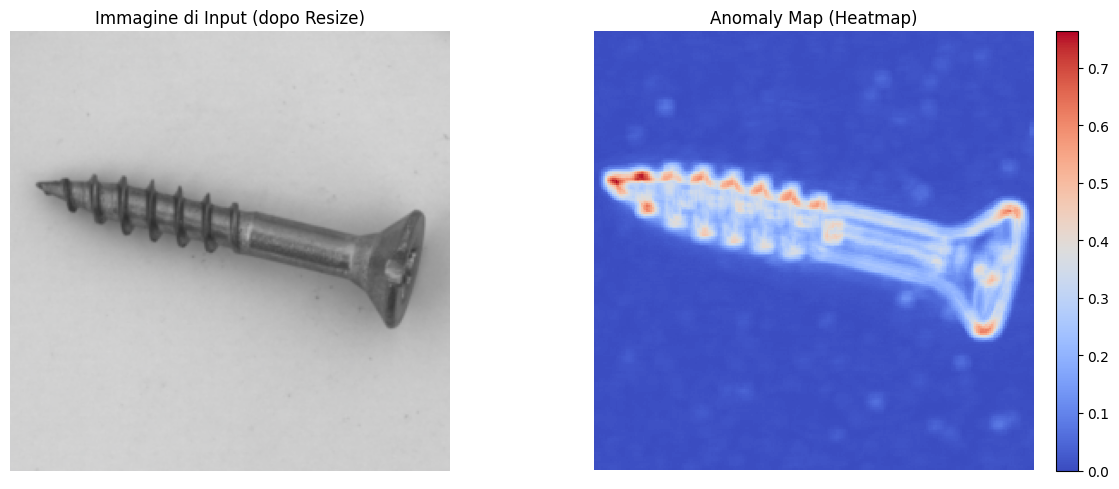

In [10]:
# Esempio di test

def rotate_image_90(img_tensor):
    """
    Ruota un'immagine torch.Tensor di 90 gradi in senso orario.
    img_tensor: torch.Tensor di shape (C, H, W)
    """
    return img_tensor.flip(2).transpose(1, 2)

index = 66
patch_size = 5
stride = 1
padding = 1
reduction = 'max'

print("\nTesting with a sample image...")
test_dataset = MVTecDataset(category, train=False, transform=transform)
test_image_data = test_dataset[index]  # Prima immagine di test
image = test_image_data[0]

# Applica la rotazione all'immagine di test
# image = rotate_image_90(image)  # Immagine trasformata e ruotata
label = test_image_data[1]  # Tipo di anomalia o 'good



anomalies , lista = detect_anomalies(image, sub_bank, model, device ,stride=stride , patch_size=patch_size , padding=padding , reduction=reduction)
print(f"Anomaly scores for test image: mean={anomalies.mean():.4f}, max={anomalies.max():.4f} , label={label}")
normalized_scores = normalize_anomaly_scores(anomalies, method='percentile75', activation='exp' , k=3)
plot_anomaly_detection(image, normalized_scores)

In [ ]:
normalized_scores

array([24.54804511, 24.0462901 , 23.93881414, ..., 23.12991242,
       23.33533553, 23.82711532], shape=(64516,))

In [ ]:
normalized_scores.max()

np.float64(0.2895057786173789)

In [ ]:
def normalize_anomaly_scores(anomaly_scores, method='mean', activation='relu', k=1):
    """
    Normalizza l'array degli anomaly scores in modo che il valore di threshold (media, mediana, 75 percentile, mean+std) sia portato a 0 o 1.
    L'output può essere passato attraverso una funzione di attivazione: relu, tanh, sigmoid, exp.

    Args:
        anomaly_scores: array numpy o torch 1D
        method: 'mean', 'median', 'percentile75', 'mean+std' per la soglia
        activation: 'relu', 'tanh', 'sigmoid' , 'exp' (default 'relu')
        k: fattore di scala per 'exp' (default=1)
    Returns:
        anomaly_scores_norm: array numpy normalizzato e attivato
    """
    import numpy as np
    from scipy.special import expit # sigmoid
    if isinstance(anomaly_scores, (list, tuple)):
        anomaly_scores = np.array(anomaly_scores)
    elif hasattr(anomaly_scores, 'cpu'):
        anomaly_scores = anomaly_scores.cpu().numpy()
    
    if method == 'mean':
        threshold = anomaly_scores.mean()
    elif method == 'median':
        threshold = np.median(anomaly_scores)
    elif method == 'percentile75':
        threshold = np.percentile(anomaly_scores, 75)
    elif method == 'mean+std':
        threshold = anomaly_scores.mean() + anomaly_scores.std()
    else:
        raise ValueError("method deve essere 'mean', 'median', 'percentile75' o 'mean+std'")
    
    anomaly_scores_norm = anomaly_scores - threshold

    # Funzione di attivazione
    if activation == 'relu':
        anomaly_scores_norm = np.maximum(anomaly_scores_norm, 0)
    elif activation == 'tanh':
        anomaly_scores_norm = np.tanh(anomaly_scores_norm)
    elif activation == 'sigmoid':
        anomaly_scores_norm = expit(anomaly_scores_norm)
    elif activation == 'exp':
        # Shift per avere il minimo a zero PRIMA di applicare exp
        anomaly_scores_norm = anomaly_scores_norm - anomaly_scores_norm.min()
        anomaly_scores_norm = np.exp(anomaly_scores_norm * k) - 1
    else:
        raise ValueError("activation deve essere 'relu', 'tanh', 'sigmoid' o 'exp'")
    return anomaly_scores_norm


In [ ]:
aaaa = np.array([0.1, 0.5, 0.3, 0.7, 0.2])
bbb =normalize_anomaly_scores(aaaa, method='percentile75', activation='exp' , k=20)

In [ ]:
bbb

array([0.00000000e+00, 2.97995799e+03, 5.35981500e+01, 1.62753791e+05,
       6.38905610e+00])

In [ ]:
feature_bank

tensor([[0.0540, 0.0506, 0.0675,  ..., 0.0000, 0.0420, 0.1040],
        [0.0393, 0.0674, 0.0511,  ..., 0.0000, 0.0362, 0.0708],
        [0.0374, 0.0620, 0.0340,  ..., 0.0000, 0.0362, 0.0708],
        ...,
        [0.0366, 0.0482, 0.0426,  ..., 0.0000, 0.0299, 0.0145],
        [0.0382, 0.0482, 0.0472,  ..., 0.0000, 0.0299, 0.0256],
        [0.0335, 0.0772, 0.1042,  ..., 0.0000, 0.0586, 0.0504]])

In [ ]:
img = []
for element  in lista :
    dist = element['distances'].min().item()
    img.append(dist)

In [ ]:
len(img)

64516

In [ ]:
anomalies

array([0.43517014, 0.38314724, 0.36417332, ..., 0.27762282, 0.30467331,
       0.34797943], shape=(60516,))

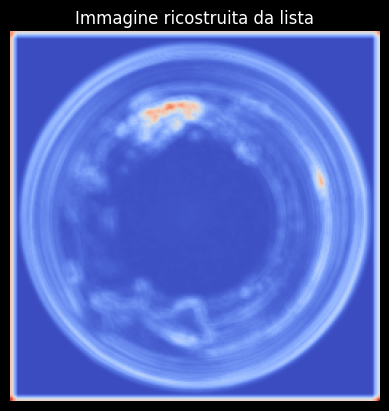

In [ ]:
import numpy as np

# Supponendo che la lista si chiami img e abbia 254*254 elementi
img_array = np.array(img).reshape(254, 254)

plt.imshow(img_array, cmap='coolwarm')
plt.title('Immagine ricostruita da lista')
plt.axis('off')
plt.show()

In [ ]:
lista

[{'patch': tensor([0.0512, 0.0388, 0.0237, 0.0641, 0.0496, 0.0000, 0.0057, 0.0493, 0.0460,
          0.0748, 0.0124, 0.0130, 0.0097, 0.0000, 0.0337, 0.0547, 0.0183, 0.0288,
          0.0000, 0.1599, 0.0360, 0.0205, 0.0401, 0.0052, 0.1134, 0.0000, 0.0413,
          0.0039, 0.0453, 0.0000, 0.0969, 0.0619, 0.0578, 0.0142, 0.0000, 0.0360,
          0.1169, 0.0091, 0.0475, 0.0792, 0.0761, 0.0000, 0.0420, 0.0286, 0.0669,
          0.0098, 0.0675, 0.0547, 0.0374, 0.0000, 0.0443, 0.0658, 0.1365, 0.0519,
          0.0057, 0.0538, 0.0620, 0.0093, 0.0299, 0.0187, 0.0316, 0.0000, 0.0547,
          0.0000, 0.0296, 0.0000, 0.0040, 0.0599, 0.0502, 0.0854, 0.0157, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0438, 0.0000, 0.0165, 0.0522, 0.0497, 0.0241,
          0.0435, 0.0054, 0.0000, 0.0401, 0.0593, 0.0670, 0.0534, 0.0193, 0.0031,
          0.0547, 0.0000, 0.0898, 0.0000, 0.0324, 0.0987, 0.0855, 0.0000, 0.0171,
          0.0176]),
  'distances': tensor([0.2601, 0.2497, 0.2497,  ..., 0.3128, 0.2420, 